In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import pickle
from PIL import Image
from glob import glob
%matplotlib inline

In [2]:
anger = glob('anger/*.png')
contempt = glob('contempt/*.png')
disgust = glob('disgust/*.png')
fear = glob('fear/*.png')
happy = glob('happy/*.png')
sadness = glob('sadness/*.png')
surprise = glob('surprise/*.png')

In [3]:
big = anger + contempt + disgust + fear + happy + sadness + surprise

In [4]:
big[:3]

['anger\\S010_004_00000017.png',
 'anger\\S010_004_00000018.png',
 'anger\\S010_004_00000019.png']

In [49]:
def getSize(file):
    # go through every image and return the size 
    img = Image.open(file)
    return img.size[0]

In [50]:
df = pd.DataFrame(data=big, columns=['path'])

In [51]:
df['size'] = df['path'].apply(getSize)

In [52]:
df.describe()

,size
count,981.0
mean,48.0
std,0.0
min,48.0
25%,48.0
50%,48.0
75%,48.0
max,48.0


In [53]:
# take string from the path to find the label
string = df['path'][0]

In [54]:
string

'anger\\S010_004_00000017.png'

In [55]:
string.split('\\')[0]

'anger'

In [56]:
def lab(string):
    try:
        return string.split('\\')[0]
    except:
        return None

In [57]:
df['feeling'] = df['path'].apply(lab)

In [58]:
df

,path,size,feeling
0,anger\S010_004_00000017.png,48,anger
1,anger\S010_004_00000018.png,48,anger
2,anger\S010_004_00000019.png,48,anger
3,anger\S011_004_00000019.png,48,anger
4,anger\S011_004_00000020.png,48,anger
...,...,...,...
976,surprise\S137_001_00000013.png,48,surprise
977,surprise\S137_001_00000014.png,48,surprise
978,surprise\S138_004_00000011.png,48,surprise
979,surprise\S138_004_00000012.png,48,surprise


In [59]:
def transforming(path_to_resize):

    img = cv2.imread(path_to_resize)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    return img

In [60]:
df['image'] = df['path'].apply(transforming)

In [61]:
# encode categorical
df['feeling'] = df['feeling'].astype('category')
df.dtypes

path         object
size          int64
feeling    category
image        object
dtype: object

In [62]:
df['feeling'] = df['feeling'].cat.codes
#anger = 0, contempt = 1, disgust = 2, fear = 3, happy = 4, sadness = 5, surprise = 6

,path,size,feeling,image
0,anger\S010_004_00000017.png,48,0,"[[[24, 24, 24], [10, 10, 10], [13, 13, 13], [1..."
1,anger\S010_004_00000018.png,48,0,"[[[17, 17, 17], [10, 10, 10], [16, 16, 16], [1..."
2,anger\S010_004_00000019.png,48,0,"[[[27, 27, 27], [13, 13, 13], [10, 10, 10], [1..."
3,anger\S011_004_00000019.png,48,0,"[[[36, 36, 36], [32, 32, 32], [17, 17, 17], [1..."
4,anger\S011_004_00000020.png,48,0,"[[[31, 31, 31], [39, 39, 39], [19, 19, 19], [1..."


In [64]:
df.drop(['path', 'size'], axis=1,inplace=True)

In [65]:
#shuffle
df = df.sample(frac = 1) 

In [66]:
df['image'][0].shape

(48, 48, 3)

In [67]:
y = df.iloc[:, 0].values

In [68]:
x = np.asarray(df['image'].tolist())

In [69]:
x.shape

(981, 48, 48, 3)

In [70]:
y.shape

(981,)

In [2]:
import keras
import itertools

from keras.utils.np_utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from sklearn.model_selection import train_test_split


In [103]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(x,y, test_size=0.25)

In [104]:
x_train = X_TRAIN / 255
x_test = X_TEST / 255
y_train = Y_TRAIN#np.asarray(Y_TRAIN).astype('float32').reshape((-1,1))
y_test = Y_TEST#np.asarray(Y_TEST).astype('float32').reshape((-1,1))

In [105]:
x_train.shape

(735, 48, 48, 3)

In [106]:
y_train.shape

(735,)

In [107]:
from keras.callbacks import Callback

In [145]:
class myCallBack(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('accuracy') > 0.999):
            self.model.stop_training = True

callback=myCallBack()

In [146]:
input_shape = (48, 48, 3)

model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=input_shape,
                        kernel_regularizer=regularizers.l2(0.001),padding="same"))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7,activation='softmax'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 9, 9, 128)         73856     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 2, 2, 256)        

In [147]:
model.compile(optimizer = 'adam' , loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [148]:
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1 # Randomly zoom image 
)
# Fit the model
#validation_data=(x_val,y_val)
epochs = 50
batch_size = 32
model.fit(x_train,y_train, batch_size=batch_size,
                              epochs = epochs,
                              verbose = 1,
                              callbacks=[callback]
                              )

Epoch 1/50
23/23 [==============================] - 2s 47ms/step - loss: 1.8779 - accuracy: 0.2138
Epoch 2/50
23/23 [==============================] - 1s 48ms/step - loss: 1.8511 - accuracy: 0.2120
Epoch 3/50
23/23 [==============================] - 1s 49ms/step - loss: 1.8036 - accuracy: 0.2602
Epoch 4/50
23/23 [==============================] - 1s 49ms/step - loss: 1.5908 - accuracy: 0.4512
Epoch 5/50
23/23 [==============================] - 1s 48ms/step - loss: 1.0037 - accuracy: 0.6368
Epoch 6/50
23/23 [==============================] - 1s 50ms/step - loss: 0.7142 - accuracy: 0.7146
Epoch 7/50
23/23 [==============================] - 1s 50ms/step - loss: 0.5410 - accuracy: 0.8054
Epoch 8/50
23/23 [==============================] - 1s 49ms/step - loss: 0.3880 - accuracy: 0.8660
Epoch 9/50
23/23 [==============================] - 1s 49ms/step - loss: 0.3179 - accuracy: 0.8927
Epoch 10/50
23/23 [==============================] - 1s 52ms/step - loss: 0.2974 - accuracy: 0.8811
Epoch 11/

In [156]:
model.save('100_feeling.h5')

In [1]:
import cv2
from keras.models import load_model

In [2]:
model = load_model('100_feeling.h5')

In [3]:
from keras.preprocessing import image

In [7]:
from PIL import Image
from skimage import transform
import matplotlib.pyplot as plt
import numpy as np

In [8]:
haar = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
def prediction(img, model):
    
    img = cv2.imread(img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    faces = haar.detectMultiScale(img,1.5,5)
    
    for x,y,w,h in faces:
        cropped = img[y:y+h, x:x+w]
    plt.imshow(cropped)
    np_image = np.array(cropped).astype('float32')/255

    np_image = transform.resize(np_image, (48,48,3))

    np_image = np.expand_dims(np_image, axis=0)


    pred = model.predict(np_image)
    
    prediction = np.where(pred[0] == max(pred[0]))
    prediction = prediction[0][0]
    if prediction == 0:
        print('Anger')
    elif prediction == 1:
        print('Contempt')
    elif prediction == 2:
        print('Disgust')
    elif prediction == 3:
        print('Fear')
    elif prediction == 4:
        print('Happy')
    elif prediction == 5:
        print('Sadness')
    elif prediction == 6:
        print('Surprise')

Happy


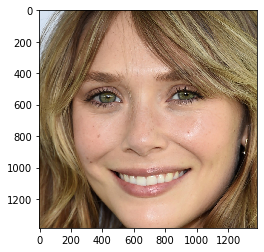

In [10]:
prediction('elizabeth_olsen.jpg', model)

Anger


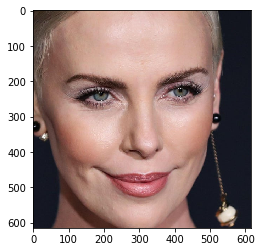

In [11]:
prediction('charlize_theron.jpg', model)

Contempt


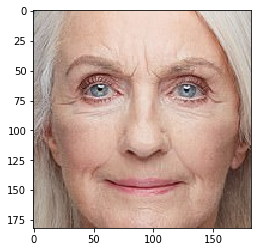

In [12]:
prediction('old_lady.jpg', model)

Fear


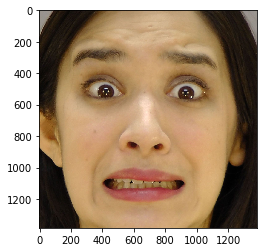

In [13]:
prediction('fear_lady.jpg', model)

Surprise


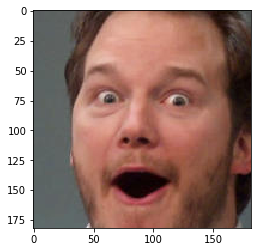

In [15]:
prediction('surprise_andy.jpg', model)